In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import datetime
import random
from dateutil import parser
from tqdm import tqdm

from fbprophet import Prophet
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
start_time = '2021-01-31 00:00:00'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

In [10]:
data_path = './data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
# test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

In [11]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [12]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
# test_x_array = df2d_to_array3d(test_x_df)

In [13]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
''')


train_x_array (7661, 1380, 10)
train_y_array (7661, 120, 10)



# 3. EDA

In [14]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

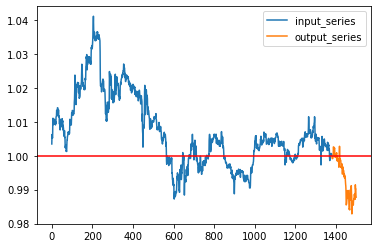

In [15]:
idx = 42
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1])
plt.show()

# 4. Parameter Optimization

fbprophet 모델에 MAPE를 기준으로 grid searching을 적용했습니다. 학습이 상당히 오래 걸립니다.

In [ ]:
params_grid = {'changepoint_prior_scale':[0.1,0.01,0.001],
               'n_changepoints' : [50,100,150],
               'fourier_order' : [5,10],
               'period':[0.1,0.3,0.5]
               }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 54


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
model_parameters = pd.DataFrame(columns = ['idx',
                                           'MAPE',
                                           'changepoint_prior_scale',
                                           'n_changepoints',
                                           'fourier_order',
                                           'period'
                                           ])

random.seed(42)
samples = random.sample(range(7661),10)
for idx in tqdm(samples, position=1):
    x_series = train_x_array[idx,:,1]
    y_series = train_y_array[idx,:,1]
    x_df = pd.DataFrame()
    x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
    x_df['y'] = x_series.tolist()
    for p in tqdm(grid, position=0):
        prophet = Prophet(seasonality_mode='multiplicative', 
                          yearly_seasonality=False,
                          weekly_seasonality=False,
                          daily_seasonality=False,
                          changepoint_prior_scale=p['changepoint_prior_scale'],
                          n_changepoints=p['n_changepoints'],
                          )
        prophet.add_seasonality(name='seasonality_1',period=p['period'],fourier_order=p['fourier_order'])
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]

        MAPE = mean_absolute_percentage_error(y_series,pred_y)
        model_parameters = model_parameters.append({'idx':idx,
                                                    'MAPE':MAPE,
                                                    'changepoint_prior_scale':p['changepoint_prior_scale'],
                                                    'n_changepoints':p['n_changepoints'],
                                                    'fourier_order':p['fourier_order'],
                                                    'period':p['period']
                                                    },ignore_index=True)

위의 셀을 실행하여 MAPE가 최소가 되는 값을 찾았습니다. 추가적으로 2개의 seasonality를 더해서 모델 성능을 높였습니다.

In [ ]:
idx = 42
x_series = train_x_array[idx,:,1]
  
x_df = pd.DataFrame()
x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
x_df['y'] = x_series.tolist()

prophet = Prophet(seasonality_mode='multiplicative', 
          yearly_seasonality=False,
          weekly_seasonality=False,
          daily_seasonality=False,
          changepoint_prior_scale=0.1,
          n_changepoints=50
          )
prophet.add_seasonality(name='seasonality_1',period=0.1,fourier_order = 5)
prophet.add_seasonality(name='seasonality_2', period=0.3,fourier_order = 5)
prophet.add_seasonality(name='seasonality_3', period=0.01, fourier_order = 5)
prophet.fit(x_df)

future_data = prophet.make_future_dataframe(periods=120, freq='min')
forecast_data = prophet.predict(future_data)

pred_y = forecast_data.yhat.values[-120:]
pred_y_lower = forecast_data.yhat_lower.values[-120:]
pred_y_upper = forecast_data.yhat_upper.values[-120:]

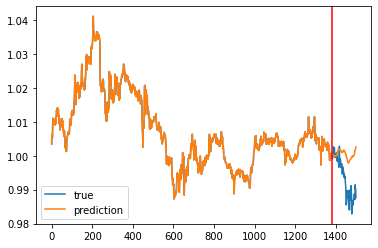

In [123]:
plt.plot(np.hstack([train_x_array[idx,:,1], train_y_array[idx,:,1]]), label='true')
plt.plot(np.hstack([train_x_array[idx,:,1], pred_y]), label='prediction')
plt.legend()
plt.axvline(1380, c='red')

# Training

In [ ]:
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])
for idx in tqdm(range(test_x_array.shape[0]), position=0):
    
    x_series = test_x_array[idx,:,1]
  
    x_df = pd.DataFrame()
    x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
    x_df['y'] = x_series.tolist()

    prophet = Prophet(seasonality_mode='multiplicative', 
              yearly_seasonality=False,
              weekly_seasonality=False,
              daily_seasonality=False,
              changepoint_prior_scale=0.1,
              n_changepoints=50
              )
    prophet.add_seasonality(name='seasonality_1',period=0.1,fourier_order = 5)
    prophet.add_seasonality(name='seasonality_2', period=0.3,fourier_order = 5)
    prophet.add_seasonality(name='seasonality_3', period=0.01, fourier_order = 5)
    prophet.fit(x_df)

    # 120분 테스트 데이터를 예측합니다.
    future_data = prophet.make_future_dataframe(periods=120, freq='min')
    forecast_data = prophet.predict(future_data)

    pred_y = forecast_data.yhat.values[-120:]

    test_pred_array[idx,:] = pred_y

100%|██████████| 535/535 [1:55:25<00:00, 12.95s/it]


베이스라인 코드에 있었던 100%의 매수 방식을 그대로 유지했습니다. threshold는 상위 3% 정도를 매수하도록 조정해 주었습니다.

In [ ]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.07) * 1
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    submission['sample_id'] = submission['sample_id'].apply(lambda x: x+7661)
    return submission

# Submit

In [ ]:
submission = array_to_submission(test_x_array, test_pred_array)

In [ ]:
submission['buy_quantity'].value_counts()

0    518
1     17
Name: buy_quantity, dtype: int64

In [125]:
submission.to_csv('/content/gdrive/My Drive/data/bit_trader_season2.csv', index=False)